### NFI Cumulative Distribution Function plots and statistics for the Glacier Bay VQOR
These for GLBARENDU2011, GLBAMCLEOD2011 (re-analyzed from original [Lynch E. 2012. *Glacier Bay National Park and Preserve: Acoustical Monitoring 2011*](https://irma.nps.gov/DataStore/Reference/Profile/2268564)), and subsequent monitoring GLBARENDU2021, GLBAMCLEOD2021. <br>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import os

# general NSNSD acoustical tools
import sys
sys.path.append(r"C:\Users\DBetchkal\PythonScripts\3_GITHUB_REPOSITORIES\iyore")
sys.path.append(r"C:\Users\DBetchkal\PythonScripts\3_GITHUB_REPOSITORIES\soundDB")
sys.path.append(r"C:\Users\DBetchkal\PythonScripts\3_GITHUB_REPOSITORIES\derivedDataFunctions")
sys.path.append(r"C:\Users\DBetchkal\PythonScripts\3_GITHUB_REPOSITORIES\GLBA-vesselAcoustics")
import iyore
from soundDB import *
from derivedDataFunctions import *
from merge_SRCID import *
from AIS_utilities import contiguous_regions


def VOQR_cumulative_histogram_nfi(ds, unit, site, year):
    
    '''
    Analyze spectrogram annotations for a site to make a CDF plot.
    Work under conditions of the GLBA Vessel Operating and Quota Requirements plan.
    '''

    src = srcid(ds, unit=unit, site=site, year=year).combine()
    src_m = merge_SRCID(src) # merging is important because vessels often span multiple hours
    
    n_days = number_of_days_splatted(src_m)

    # extract only vessel events; a condition of the VQoR
    # in this analysis: 
    #     AIS-derived vessels use a 4-character srcID mapped to MMSI (e.g., '0.702')
    #     other vessels have the conventional srcID (i.e., '3.0')
    vessel_events = src_m.loc[(src_m.srcID == 3)|(src_m.srcID.astype('str').str.len() == 5), :].copy()
    
    print(vessel_events)

    # they must be sorted
    vessel_events.sort_index(inplace=True)
    
    # this is by far more straightforward 
    NFIlst = vessel_events.index.to_series().diff()

    # we only want non-negative intervals
    out = pd.Series(np.array([m for m in NFIlst[NFIlst > "00:00:00"]]))

    # compute noise-free intervals between all events
    nfis = NFI_list(vessel_events, unit="hours")

    # for comparing sites a constant number of bins is required; let's use 100
    val, base = np.histogram(nfis, bins=np.logspace(-2,2, 200))

    #evaluate the cumulative
    cumu = np.cumsum(val)/max(np.cumsum(val))
    
    # compute time audible as a percentage of the overall record
    # note: this computation assumes partial days have been separated at the archive level
    TA_p = 100*src_m.loc[:, "len"].sum().total_seconds()/(3600*len([e for e in ds.nvspl(unit=u, site=s, year=y)]))
    
    NFI_80thP = np.around(np.percentile(nfis, 80), decimals=1)
    NFI_70thP = np.around(np.percentile(nfis, 70), decimals=1)
    NFI_50thP = np.around(np.percentile(nfis, 50), decimals=1)
    NFI_mean = np.around(np.mean(nfis), decimals=1)
    print("80th = {0:.1f} hours".format(NFI_80thP),
          "70th = {0:.1f} hours".format(NFI_70thP),
          "mean = {0:.1f} hours".format(NFI_mean),
          "50th = {0:.1f} hours".format(NFI_50thP),
          "\n\n")
    
    metrics = [n_days, NFI_50thP, NFI_mean, NFI_70thP, NFI_80thP]
    
    return base, cumu, TA_p, metrics

def VOQR_cumulative_histogram_sel(ds, unit, site, year):
    
    '''
    Analyze spectrogram annotations for a site to make a CDF plot.
    Work under conditions of the GLBA Vessel Operating and Quota Requirements plan.
    '''

    src = srcid(ds, unit=unit, site=site, year=year).combine()
    src = src[~src.index.duplicated(keep='first')]
    src_m = merge_SRCID(src) # merging is important because vessels often span multiple hours

    # extract only vessel events; a condition of the VQoR
    # in this analysis: 
    #     AIS-derived vessels use a 4-character srcID mapped to MMSI (e.g., '0.702')
    #     other vessels have the conventional srcID (i.e., '3.0')
    vessel_events = src_m.loc[(src_m.srcID == 3)|(src_m.srcID.astype('str').str.len() == 5), :].copy()

    # they must be sorted
    vessel_events.sort_index(inplace=True)
    
    sels = [float(val) for val in vessel_events['SELt'].values]
    
    # for comparing sites a constant number of bins is required; let's use 100
    val, base = np.histogram(sels, bins=np.linspace(20, 130, 200))

    #evaluate the cumulative
    cumu = np.cumsum(val)/max(np.cumsum(val))
    
    return base, cumu

def html_table(list_of_lists):
    print('<table>')
    for sublist in list_of_lists:
        print('  <tr><td>')
        print('    </td><td>'.join(sublist))
        print('  </td></tr>')
    print('</table>')

### Step One: plot overall vessel NFIs, SELs as Cumulative Distribution Functions
we'll also produce a simple HMTL table summarizing the results

now processing GLBARENDU2011


  0%|          | 0/1 [00:00<?, ?entries/s]

                                len srcID  Hz_L   Hz_U MaxSPL   SEL MaxSPLt  \
2011-08-04 06:40:00 0 days 00:05:48   3.0  31.5  160.0   45.2  60.6    36.5   
2011-08-04 07:00:06 0 days 01:10:17   3.0  25.0  100.0   55.2  75.6    53.1   
2011-08-04 08:00:00 0 days 00:10:24   3.0  25.0  100.0   48.4  66.2    38.9   
2011-08-04 08:14:03 0 days 00:02:28   3.0  50.0  125.0   42.2  60.0    38.4   
2011-08-04 08:21:38 0 days 00:19:58   3.0  50.0   80.0   56.8  77.5    54.5   
...                             ...   ...   ...    ...    ...   ...     ...   
2011-08-25 15:00:00 0 days 00:08:47   3.0  25.0  500.0   47.4  61.5    40.8   
2011-08-25 16:11:57 0 days 00:04:01   3.0  20.0  400.0   36.8  53.6    31.1   
2011-08-25 16:22:46 0 days 00:06:02   3.0  25.0  500.0   44.3  60.7    38.4   
2011-08-25 17:00:00 0 days 00:56:25   3.0  20.0  500.0   50.5  69.2    43.0   
2011-08-25 17:57:37 0 days 00:02:22   3.0  25.0  400.0   31.6  51.1    27.6   

                     SELt   userName             ta

  0%|          | 0/1 [00:00<?, ?entries/s]

                                len  srcID  Hz_L  Hz_U MaxSPL   SEL MaxSPLt  \
2021-05-14 16:51:44 0 days 00:06:57    3.0  12.5  1250   42.4  63.0    41.0   
2021-05-15 07:05:24 0 days 00:07:46    3.0  12.5   160   40.9  61.6    40.5   
2021-05-15 15:03:11 0 days 00:31:30    3.0  12.5   400   46.8  66.7    46.2   
2021-05-16 07:14:27 0 days 00:18:51  2.443  12.5   125   51.2  76.5    48.7   
2021-05-16 11:25:36 0 days 00:23:53    3.0  12.5   200   66.0  79.7    65.4   
...                             ...    ...   ...   ...    ...   ...     ...   
2021-09-21 13:30:50 0 days 00:13:15    3.0  12.5   200   58.3  83.4    56.9   
2021-09-23 09:09:09 0 days 00:13:03    3.0  12.5    63   58.0  78.7    54.8   
2021-09-23 13:02:06 0 days 00:10:59  3.191  12.5    63   49.8  70.9    48.6   
2021-09-25 14:25:52 0 days 00:13:34    3.0  12.5   200   46.1  63.9    45.6   
2021-09-25 14:43:06 0 days 00:07:13    3.0  12.5   200   40.2  56.5    38.5   

                     SELt userName             tagD

  0%|          | 0/1 [00:00<?, ?entries/s]

                                len srcID  Hz_L  Hz_U MaxSPL   SEL MaxSPLt  \
2011-08-20 10:41:14 0 days 00:09:52   3.0  20.0  2000   69.0  70.9    68.1   
2011-08-20 11:35:18 0 days 00:12:34   3.0  25.0  2500   57.0  67.1    55.3   
2011-08-20 14:01:52 0 days 00:05:07   3.0  25.0   500   46.8  57.5    34.3   
2011-08-20 14:13:37 0 days 00:16:10   3.0  20.0  2500   51.5  65.6    40.8   
2011-08-20 14:44:44 0 days 00:07:14   3.0  20.0  8000   50.3  66.4    49.3   
...                             ...   ...   ...   ...    ...   ...     ...   
2011-09-10 16:04:32 0 days 00:05:52   3.0  12.5  1600   34.1  54.0    33.5   
2011-09-10 17:01:33 0 days 00:07:25   3.0  12.5  1000   35.5  54.0    35.2   
2011-09-10 17:31:23 0 days 00:05:07   3.0  12.5  1000   33.1  52.8    32.5   
2011-09-10 17:44:13 0 days 00:07:05   3.0  12.5  1000   34.7  52.8    33.3   
2011-09-10 18:01:01 0 days 00:20:14   3.0  12.5   315   47.3  58.9    46.9   

                     SELt   userName             tagDate  
2011

  0%|          | 0/1 [00:00<?, ?entries/s]

                                len  srcID  Hz_L   Hz_U MaxSPL   SEL MaxSPLt  \
2021-05-11 11:55:47 0 days 00:04:13  1.011  12.5   2000    0.0   0.0     0.0   
2021-05-11 18:02:35 0 days 00:57:25  2.367  12.5   2000    0.0   0.0     0.0   
2021-05-13 11:37:43 0 days 00:02:16    3.0  12.5    630   57.8  70.7    57.0   
2021-05-13 11:44:35 0 days 00:01:03    3.0  12.5   1000   56.7  66.0    49.8   
2021-05-13 11:47:24 0 days 00:09:04    3.0  12.5  12500   57.8  74.1    55.4   
...                             ...    ...   ...    ...    ...   ...     ...   
2021-09-28 13:31:02 0 days 00:19:47    3.0  12.5   5000   53.3  72.0    53.3   
2021-10-04 16:18:02 0 days 00:20:38  1.011  12.5  10000   59.3  65.9    44.0   
2021-10-04 17:53:07 0 days 00:27:37  1.011  12.5  12500   53.8  67.6    52.0   
2021-10-04 18:00:00 0 days 00:20:45  1.011  12.5  12500   53.8  67.5    52.0   
2021-10-05 17:19:55 0 days 00:07:51    3.0  12.5   1000   45.1  60.6    43.2   

                     SELt     userName 

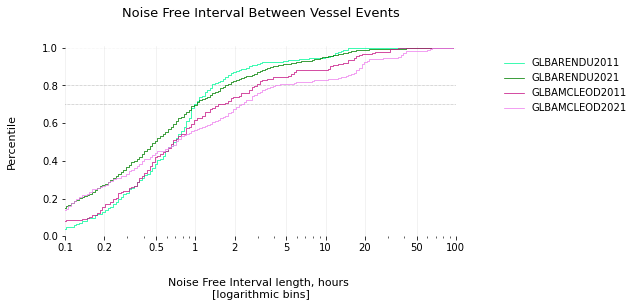

<table>
  <tr><td>
Site location    </td><td>days measured    </td><td>median (hrs)    </td><td>mean (hrs)    </td><td>70th percentile (hrs)    </td><td>80th percentile (hrs)
  </td></tr>
  <tr><td>
GLBARENDU2011    </td><td>22    </td><td>0.7    </td><td>1.6    </td><td>1.1    </td><td>1.4
  </td></tr>
  <tr><td>
GLBARENDU2021    </td><td>114    </td><td>0.5    </td><td>2.4    </td><td>1.1    </td><td>1.9
  </td></tr>
  <tr><td>
GLBAMCLEOD2011    </td><td>22    </td><td>0.7    </td><td>3.3    </td><td>1.6    </td><td>3.1
  </td></tr>
  <tr><td>
GLBAMCLEOD2021    </td><td>137    </td><td>0.8    </td><td>7.1    </td><td>2.5    </td><td>4.9
  </td></tr>
</table>


In [2]:
ds = iyore.Dataset(r"E:")

wdir = r"T:\ResMgmt\WAGS\Sound\Experiments & Data\2022 - 2021 GLBA VQOR Vessel Quotas and Operating Requirements plan"

# =========== plot ===================

nfi_refs = [0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100] # in hours

fig, ax = plt.subplots(1, 1, figsize=(7, 3.5))

#                   ('GLBA', 'BARTC', 2020, 'mediumblue'), # where are these?
#                   ('GLBA', 'HUTCH', 2020, 'pink'),
# for u, s, y, c in [('GLBA', 'BARTC', 2021, 'blue'),
#                    ('GLBA', 'MCLEOD', 2011, 'mediumvioletred'),
#                    ('GLBA', 'MCLEOD', 2021, 'violet'),
#                    ('GLBA', 'RENDU', 2011, 'mediumspringgreen'),
#                    ('GLBA', 'RENDU', 2020, 'orange'),
#                    ('GLBA', 'RENDU', 2021, 'green'),
#                    ('GLBA', 'REID', 2020, 'indigo'),
#                    ('GLBA', 'BEARD', 2021, 'saddlebrown'),
#                    ('GLBA', 'HUTCH', 2011, 'orangered'),
#                    ('GLBA', 'MOUSE', 2011, 'dodgerblue')]:

# we start with a header
table_data = [['Site location', 'days measured', 'median (hrs)', 'mean (hrs)',
                '70th percentile (hrs)', '80th percentile (hrs)']]

for u, s, y, c in [('GLBA', 'RENDU', 2011, 'mediumspringgreen'),
                   ('GLBA', 'RENDU', 2021, 'green'),
                   ('GLBA', 'MCLEOD', 2011, 'mediumvioletred'),
                   ('GLBA', 'MCLEOD', 2021, 'violet')]:
    
    print("now processing", u+s+str(y))
    
    # to visualize the annotations we: parse + filter + mine + represent...
    base, cumu, TA_p, metrics = VOQR_cumulative_histogram_nfi(ds, u, s, y)
    
    # process acoustic metrics for inclusion in an HTML table
    row = [u+s+str(y)] + [str(item) for item in metrics] 
    table_data.append(row)
    
    # plot the results
    ax.step(base[:-1], cumu, label=u+s+str(y), 
            lw=0.75, color=c)
    
    


ax.set_xscale('log')
ax.set_xlabel("Noise Free Interval length, hours \n[logarithmic bins]", 
              labelpad=25, fontsize=11)
ax.set_xticks(ticks=nfi_refs)
ax.set_xticklabels(labels=nfi_refs)
ax.set_xlim([0.1, 100])

# add visual cues for familiar lengths of time
# (this helps interpret the logarithmic bins)
for t in nfi_refs: 
    ax.axvline(t, lw=0.5, alpha=0.1, color="k", zorder=-2)

ax.set_ylabel("Percentile", labelpad=25, fontsize=11)
ax.set_ylim([0, 1.01])

ax.axhline(1, lw=0.5, ls="dotted", alpha=0.1, color="k", zorder=-2)

ax.axhline(0.8, lw=0.5, ls="dotted", alpha=0.6, color="k", zorder=-2)
ax.axhline(0.7, lw=0.5, ls="dotted", alpha=0.6, color="k", zorder=-2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.legend(bbox_to_anchor=(1.1, 0.9818),
          frameon=False)

ax.set_title("Noise Free Interval Between Vessel Events",
             loc="center", y=1.12, fontsize=13)

plt.savefig(wdir+os.sep+"GLBA_VOQR_VesselNFIs_MCLEOD_20221104.png", dpi=200,
            bbox_inches="tight", facecolor="white")
plt.show()


# generate an HTML table for a tidy site-by-site summary
html_table(table_data)

<table>
  <tr><td>
Site location    </td><td>days measured    </td><td>median (hrs)    </td><td>mean (hrs)    </td><td>70th percentile (hrs)    </td><td>80th percentile (hrs)
  </td></tr>
  <tr><td>
GLBARENDU2011    </td><td>22    </td><td>0.7    </td><td>1.6    </td><td>1.1    </td><td>1.4
  </td></tr>
  <tr><td>
GLBARENDU2021    </td><td>114    </td><td>0.5    </td><td>2.4    </td><td>1.1    </td><td>1.9
  </td></tr>
  <tr><td>
GLBAMCLEOD2011    </td><td>22    </td><td>0.7    </td><td>3.3    </td><td>1.6    </td><td>3.1
  </td></tr>
  <tr><td>
GLBAMCLEOD2021    </td><td>137    </td><td>0.8    </td><td>7.1    </td><td>2.5    </td><td>4.9
  </td></tr>
</table>

#### Same graphic as above, but for Sound Exposure Level (SEL)
The analysis is identical, but visualizing the results requires different contextualization

In [ ]:
ds = iyore.Dataset(r"E:")

wdir = r"T:\ResMgmt\WAGS\Sound\Experiments & Data\2022 - 2021 GLBA VQOR Vessel Quotas and Operating Requirements plan"

# =========== plot ===================

nfi_refs = [0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100] # in hours

fig, ax = plt.subplots(1, 1, figsize=(7, 3.5))

for u, s, y, c in [("GLBA", "RENDU", 2011, 'mediumspringgreen'),
                   ("GLBA", "RENDU", 2021, 'green'),
                   ("GLBA", "MCLEOD", 2011, 'mediumvioletred'),
                   ("GLBA", "MCLEOD", 2021, 'violet'),
                   ("GLBA", "BARTC", 2021, 'dodgerblue'),
                   ("GLBA", "BEARD", 2021, 'chocolate')]:
    
    print("now processing", u+s+str(y))
    
    # to visualize the annotations we: parse + filter + mine + represent...
    base, cumu,  = VOQR_cumulative_histogram_sel(ds, u, s, y)
    
    # plot the results
    ax.step(base[:-1], cumu, label=u+s+str(y), 
            lw=0.75, color=c)

# ax.set_xscale('log')
ax.set_xlabel("Sound Exposure Level [12.5 - 1250 Hz] (dB)", 
              labelpad=25, fontsize=11)
# ax.set_xticks(ticks=nfi_refs)
# ax.set_xticklabels(labels=nfi_refs)
ax.set_xlim([30, 100])

# # add visual cues for familiar lengths of time
# # (this helps interpret the logarithmic bins)
# for t in nfi_refs: 
#     ax.axvline(t, lw=0.5, alpha=0.1, color="k", zorder=-2)

ax.set_ylabel("Percentile", labelpad=25, fontsize=11)
ax.set_ylim([0, 1.01])

# ax.axhline(1, lw=0.5, ls="dotted", alpha=0.1, color="k", zorder=-2)
# ax.axhline(0.8, lw=0.5, ls="dotted", alpha=0.6, color="k", zorder=-2)
# ax.axhline(0.7, lw=0.5, ls="dotted", alpha=0.6, color="k", zorder=-2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.legend(bbox_to_anchor=(1.1, 0.9818),
          frameon=False)

ax.set_title("Sound Exposure Level (=Noise Dose) of Vessel Events",
             loc="center", y=1.12, fontsize=13)

plt.savefig(wdir+os.sep+"GLBA_VOQR_VesselSELsfirstDraft.png", dpi=200,
            bbox_inches="tight", facecolor="white")
plt.show()

### Step Two: Load and filter the annotation record

In [3]:
ds = iyore.Dataset(r"E:")
u, s, y = "GLBA", "RENDU", 2021

src = srcid(ds, unit=u, site=s, year=y).combine()
src_m = merge_SRCID(src) # merging is important because vessels often span multiple hours

# extract only vessel events; a condition of the VQoR
# in this analysis: 
#     AIS-derived vessels use a 4-character srcID mapped to MMSI (e.g., '0.702')
#     other vessels have the conventional srcID (i.e., '3.0')
vessel_events = src_m.loc[(src_m.srcID == 3)|(src_m.srcID.astype('str').str.len() == 5), :].copy()

# they must be sorted
vessel_events.sort_index(inplace=True)

  0%|          | 0/1 [00:00<?, ?entries/s]

### Step Three: Load NVSPL record, add a binary series for vessel noise presence

In [4]:
# load (part of) the acoustic record using `soundDB`
nv = nvspl(ds, unit=u, site=s, year=y).combine()
nv.index = nv.index.droplevel()

# select only the salient data we'll be working with
nv_select = nv.loc[:, "12.5":"dbA"].merge(nv["WindSpeed"], how="left", left_index=True, right_index=True)

# we want to expand all the events into a complete list of their inclusive datetimes
noisy_times = np.array([])
for start, row in vessel_events.iterrows():
    
    event_times = [start + dt.timedelta(seconds=i) for i in np.arange(0, row["len"].total_seconds())]
    noisy_times = np.append(noisy_times, event_times)


# flatten and take only the unique values, as this is a composite effort
noise_series_raw = noisy_times.flatten()
noise_series = np.unique(noise_series_raw)

# compile into a `pandas.Series` object for merging with NVSPL
noise_presence = pd.Series(np.ones(noise_series.shape), index=noise_series, name="presence")

# merge the indicator series with the acoustic data, 
# keeping all rows from the latter and assigning np.nan for all times without noise
indicator_nv = nv_select.merge(noise_presence, how="left", left_index=True, right_index=True)
indicator_nv = indicator_nv.fillna(0) # then convert np.nan -> 0

indicator_nv

  0%|          | 0/2760 [00:00<?, ?entries/s]

Interrupted while parsing "E:2021 GLBARENDU Rendu Inlet\01 DATA\NVSPL\NVSPL_GLBARENDU_2021_05_12_07.txt"


KeyboardInterrupt: 

In [ ]:
nfis_select=contiguous_regions(indicator_nv['presence'] == 0)
I_max = (nfis_select.T[1] - nfis_select.T[0]).max()/3600

### Step Four: Compute longest diurnal NFI
- group NVSPL record by date, then <br>
- subselect by desired diural period, then <br>
- group `indicator_nv['presence']` by contiguous regions with value `== 0`, that is, *noise-free seconds*
- thus: *length of group* $\equiv$ *length of noise-free interval*
- glean `max(len(group))`

In [ ]:
start_bound = 5 # "05:00"
end_bound = 21 # "21:00" # must be in the same day!

I_maxs = []
nvspl_dates = np.unique(indicator_nv.index.date)
for date in nvspl_dates:
    
    s_time = dt.time(hour=start_bound)
    s_bound = dt.datetime.combine(date, s_time)
    e_time = dt.time(hour=end_bound)
    e_bound = dt.datetime.combine(date, e_time)
    
    print("on", date, "between", s_time, "and", e_time, ":\n")
    print("\tthe longest noise-free interval")
    
    nv_select = indicator_nv.loc[s_bound:e_bound, :]

    try:
        nfis_select=contiguous_regions(nv_select['presence'] == 0)
        I_max = (nfis_select.T[1] - nfis_select.T[0]).max()/3600
        print("\tI_max = {0:.01f} hours".format(I_max))
        print("\n\n")
        I_maxs.append(I_max)
        
    except IndexError:
        print("no noise-free periods during the timeframe indicated! \n\n")
        I_maxs.append(np.nan)

longest = pd.DataFrame(np.array([I_maxs]).T, 
                       index=nvspl_dates, columns=["I_max(hrs)"])
longest

### Step Five: plot longest-NFI results for a deployment
Scale to length of diurnal period

In [ ]:
period_len = end_bound-start_bound

plt.figure(figsize=(12, 2.5))
plt.plot(longest.index, longest["I_max(hrs)"], marker="o", ms=3, color="k", ls="")
plt.axhline(period_len, ls="--", color="gray", alpha=0.2, zorder=-1)
plt.text(longest.index.min(), period_len+0.8, 
         "maximum achievable length = {0:.1f} hrs".format(period_len), 
         color="gray", alpha=0.4, zorder=-1)
plt.ylim([0, period_len + 4])
plt.ylabel("Maximum Noise-Free\nInterval Observed (hrs)", labelpad=15)
plt.title(u+s+str(y)+" maximum diurnal NFI", loc="left", y=1.04)
plt.savefig(r"C:\Users\DBetchkal\Desktop\MaximumDiurnalNFI_"+u+s+str(y)+".png",
            dpi=150, bbox_inches="tight", facecolor="white")
plt.show()

# format tabular report
print("n days observed: {0} days".format(len(longest)), "\n",
      "min observed: {0:.1f} hours".format(longest["I_max(hrs)"].min()), "\n",
      "20th percentile: {0:.1f} hours".format(longest["I_max(hrs)"].quantile(0.2)), "\n",
      "median: {0:.1f} hours".format(longest["I_max(hrs)"].quantile(0.5)), "\n",
      "mean: {0:.1f} hours".format(longest["I_max(hrs)"].mean()), "\n",
      "80th percentile: {0:.1f} hours".format(longest["I_max(hrs)"].quantile(0.8)), "\n",
      "maximum achievable: {0:.1f} hours".format(period_len), "\n", 
      "was achieved?", (longest["I_max(hrs)"] >= period_len).sum() > 0)